## **1. Import library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,  
    classification_report,
   # mean_absolute_error, 
   # mean_squared_error, 
    explained_variance_score,
    f1_score,
    precision_score,
    recall_score

)
# from sklearn.utils.class_weight import compute_class_weight

from keras.src.models import Sequential
from keras.src.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, 
    Flatten, Dropout, Dense,
)
from keras.src.optimizers import SGD
from keras.src.callbacks import LearningRateScheduler
from keras.src.callbacks import EarlyStopping

## **2. Load normalized data**

In [2]:
normalized_data = pd.read_csv('../processed_data/normalized_data.csv')
X = normalized_data.drop("attack_cat", axis=1).values
y = normalized_data["attack_cat"].values

In [3]:
X

array([[2.02463370e-03, 4.69704086e-04, 3.63042294e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08317020e-02, 1.22123062e-03, 3.44890180e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.70521550e-02, 6.57585721e-04, 1.45216918e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50000028e-07, 9.39408173e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [4]:
y

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Reshape data to match CNN input requirements
input_shape = (X.shape[1], 1)
num_classes =  len(np.unique(y))
X_train = X_train.reshape(-1, X.shape[1], 1)
X_test = X_test.reshape(-1, X.shape[1], 1)

In [7]:
# Encoder y
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

## **3. Building CNN Model**

In [8]:
# Hàm giảm learning rate theo epoch
def lr_schedule(epoch):
    return 0.01 if epoch < 30 else 0.001

In [9]:
# CNN Model
model = Sequential()

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))  # Dropout 0.4
model.add(Dense(num_classes, activation='softmax'))

d:\ML\env311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile model
optimizer = SGD(learning_rate=0.01)  # Learning rate ban đầu 0.01
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 196, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 98, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 49, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,634,186 (6.23 MB)

 Trainable params: 1,633,802 (6.23 MB)

 Non-trainable params: 384 (1.50 KB)

## **4. Training model**

In [11]:
# Training CNN model
start_time = time.time()

# Training với Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler])

end_time = time.time()

Epoch 1/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.7207 - loss: 0.7441 - val_accuracy: 0.7671 - val_loss: 0.5730 - learning_rate: 0.0100
Epoch 2/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.7625 - loss: 0.5936 - val_accuracy: 0.7746 - val_loss: 0.5549 - learning_rate: 0.0100
Epoch 3/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.7737 - loss: 0.5666 - val_accuracy: 0.7775 - val_loss: 0.5506 - learning_rate: 0.0100
Epoch 4/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.7811 - loss: 0.5512 - val_accuracy: 0.7836 - val_loss: 0.5465 - learning_rate: 0.0100
Epoch 5/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.7856 - loss: 0.5409 - val_accuracy: 0.7847 - val_loss: 0.5381 - learning_rate: 0.0100
Epoch 6/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.7896 - loss: 0.5346 - val_accuracy: 0.7906 - val_loss: 0.5309 - learning_rate: 0.0100
Epoch 7/100
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step -

In [12]:
# Dự đoán nhãn của tập test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển kết quả thành class dự đoán

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [13]:
# Save model
model.save("../models/cnn.h5")

## **5. Confusion matrix**

In [14]:
# Decode y 
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

In [15]:
# Create confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
confusion_matrix_result

array([[   27,     0,     2,   366,    24,     0,   100,     0,     0,
            0],
       [    0,     3,     4,   416,    33,     0,     7,     5,     0,
            0],
       [    0,     5,   147,  2966,    72,     7,    68,    16,    11,
            0],
       [    3,     2,    72,  8379,   206,     8,   271,   121,    18,
            0],
       [    0,     0,     2,   580,  2512,     0,  1703,    28,     6,
            0],
       [    0,     0,    32,   192,    28, 11266,    15,     3,     1,
            0],
       [    1,     0,     4,   109,   825,     7, 17612,    43,    12,
            0],
       [    0,     0,     5,   689,    25,     1,    45,  2087,     0,
            0],
       [    0,     0,     0,    84,    26,     1,    52,    36,   110,
            0],
       [    0,     0,     0,    29,     1,     2,     1,     1,     0,
            0]], dtype=int64)

In [16]:
# Compute confusion matrix
def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True
):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [17]:
target_names=[
    'Analysis', 
    'Backdoor', 
    'DoS', 
    'Exploits', 
    'Fuzzers', 
    'Generic', 
    'Normal', 
    'Reconnaissance', 
    'Shellcode', 
    'Worms'
]

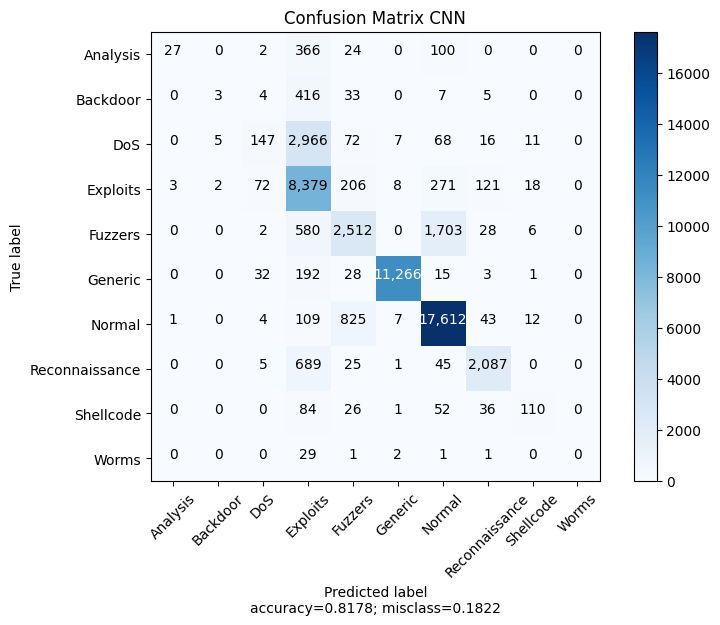

In [18]:
# Plot confusion matrix
plot_confusion_matrix(
    confusion_matrix_result, 
    normalize=False,
    target_names=target_names, 
    title="Confusion Matrix CNN"
)

## **6. Caculate metrics**

In [19]:
# Training time
training_time = end_time -start_time
print(f"Training time: {training_time/60/60:.2f} hours")

Training time: 1.42 hours


In [20]:
# Tính Detection Rate và False Positive Rate
tp = np.diag(confusion_matrix_result)  # True Positives
fn = np.sum(confusion_matrix_result, axis=1) - tp  # False Negatives
fp = np.sum(confusion_matrix_result, axis=0) - tp  # False Positives

In [21]:
detection_rate = tp / (tp + fn)
fpr = fp / (fp + np.sum(confusion_matrix_result, axis=1) - tp)
df = pd.DataFrame({"Class": target_names, "False Positive Rate": fpr, "Detection Rate": detection_rate})

# Hiển thị bảng
print(df)

            Class  False Positive Rate  Detection Rate
0        Analysis             0.008065        0.052023
1        Backdoor             0.014831        0.006410
2             DoS             0.037048        0.044654
3        Exploits             0.885682        0.922797
4         Fuzzers             0.348412        0.519975
5         Generic             0.087542        0.976510
6          Normal             0.693227        0.946220
7  Reconnaissance             0.248527        0.731767
8       Shellcode             0.194332        0.355987
9           Worms             0.000000        0.000000


In [22]:
# Hiển thị báo cáo phân loại
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

      Analysis       0.87      0.05      0.10       519
      Backdoor       0.30      0.01      0.01       468
           DoS       0.55      0.04      0.08      3292
      Exploits       0.61      0.92      0.73      9080
       Fuzzers       0.67      0.52      0.59      4831
       Generic       1.00      0.98      0.99     11537
        Normal       0.89      0.95      0.92     18613
Reconnaissance       0.89      0.73      0.80      2852
     Shellcode       0.70      0.36      0.47       309
         Worms       0.00      0.00      0.00        34

      accuracy                           0.82     51535
     macro avg       0.65      0.46      0.47     51535
  weighted avg       0.81      0.82      0.79     51535



d:\ML\env311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ML\env311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ML\env311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# print("Mean Absolute Error - ", mean_absolute_error(y_test, y_pred))
# print("Mean Squared Error - ", mean_squared_error(y_test, y_pred))
# print("Root Mean Squared Error - ", np.sqrt(mean_squared_error(y_test, y_pred)))
# print("R2 Score - ", explained_variance_score(y_test, y_pred) * 100)
print("F1 Score (weighted): ", f1_score(y_test, y_pred, average='weighted') * 100)
print("Accuracy - ",accuracy_score(y_test, y_pred, average='weighted') * 100)
print("Precision - ",precision_score(y_test, y_pred, average='weighted') * 100)
print("Recall - ", recall_score(y_test, y_pred, average='weighted') * 100)

Mean Absolute Error -  0.35919278160473467
Mean Squared Error -  0.943727563791598
Root Mean Squared Error -  0.9714564137374347
R2 Score -  60.413434821197896
F1 Score (weighted):  78.90615132407812
Accuracy -  81.77549238381683
